In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

In [3]:
atributes = list(df)[1:6]
df_for_training = df[atributes].astype(float)

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [5]:
trainX = []
trainY = []

n_past = 14
n_future = 1

In [6]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 4])

In [7]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('Dataframe shape == {}.'.format(df.shape))

trainX shape == (5373, 14, 5).
trainY shape == (5373, 1).
Dataframe shape == (5387, 7).


In [8]:
dates = df["Date"][n_past:]
dates = dates.to_numpy()
dates.shape

(5373,)

In [9]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], trainX[:q_80], trainY[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], trainX[q_80:q_90], trainY[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], trainX[q_90:], trainY[q_90:]

In [10]:
model = Sequential()
model.add(LSTM(32,input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(128, activation= "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation= "relu"))
model.add(Dense(trainY.shape[1]))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 32)            4864      
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            24832     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [12]:
cp1 = ModelCheckpoint('model/', save_best_only=True)

model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])

In [13]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1])

Epoch 1/50
135/135 [==============================] - 34s 192ms/step - loss: 0.0245 - mean_absolute_error: 0.0903 - val_loss: 0.1159 - val_mean_absolute_error: 0.2679
Epoch 2/50
135/135 [==============================] - 7s 53ms/step - loss: 0.0031 - mean_absolute_error: 0.0425 - val_loss: 0.3864 - val_mean_absolute_error: 0.5208
Epoch 3/50
135/135 [==============================] - 5s 36ms/step - loss: 0.0027 - mean_absolute_error: 0.0388 - val_loss: 0.2502 - val_mean_absolute_error: 0.4007
Epoch 4/50
135/135 [==============================] - 5s 39ms/step - loss: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.3813 - val_mean_absolute_error: 0.5230
Epoch 5/50
135/135 [==============================] - 6s 44ms/step - loss: 0.0021 - mean_absolute_error: 0.0344 - val_loss: 0.2275 - val_mean_absolute_error: 0.3873
Epoch 6/50
135/135 [==============================] - 5s 35ms/step - loss: 0.0021 - mean_absolute_error: 0.0340 - val_loss: 0.2339 - val_mean_absolute_error: 0.3962
Epoch 7/

In [14]:
model = load_model('model/')

In [29]:
model.save('TCS_Stock_Market_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
ytr = np.repeat(y_train, df_for_training.shape[1], axis=-1)
y_train_rvsc = scaler.inverse_transform(ytr)[:,4]

In [16]:
yv = np.repeat(y_val, df_for_training.shape[1], axis=-1)
y_val_rvsc = scaler.inverse_transform(yv)[:,4]

In [17]:
yt = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_test_rvsc = scaler.inverse_transform(yt)[:,4]

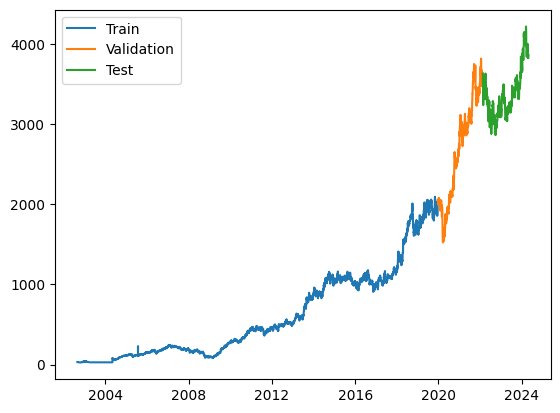

In [18]:

plt.plot(dates_train, y_train_rvsc)
plt.plot(dates_val, y_val_rvsc)
plt.plot(dates_test, y_test_rvsc)

plt.legend(['Train', 'Validation', 'Test'])

In [19]:
train_predictions = model.predict(X_train).flatten().reshape(-1,1)

135/135 [==============================] - 7s 15ms/step


In [20]:
trp = np.repeat(train_predictions, df_for_training.shape[1], axis=-1)
train_predictions_rvsc = scaler.inverse_transform(trp)[:,4]

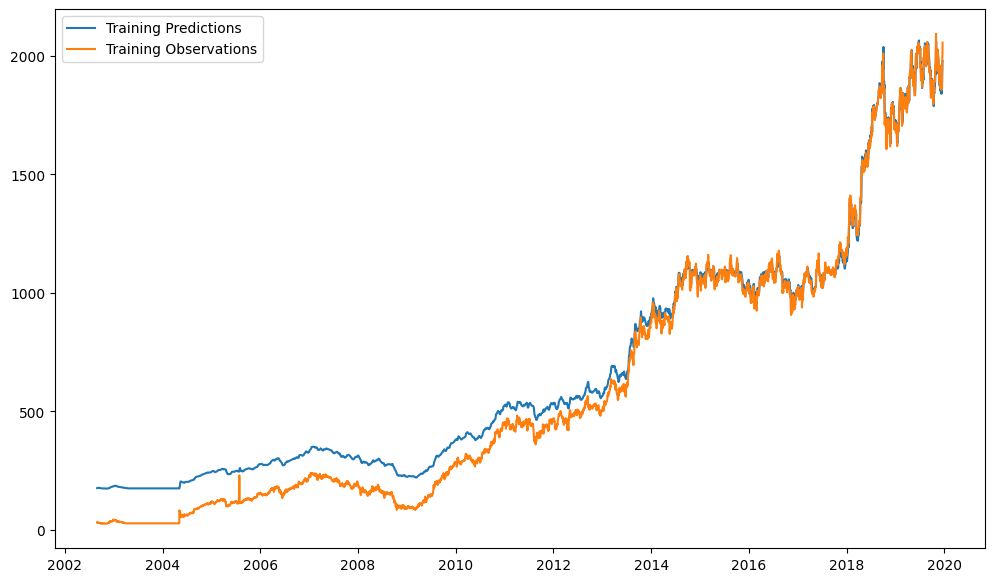

In [21]:
plt.figure(figsize=(12, 7))
plt.plot(dates_train, train_predictions_rvsc)
plt.plot(dates_train, y_train_rvsc)
plt.legend(['Training Predictions', 'Training Observations'])

In [22]:
val_predictions = model.predict(X_val).flatten().reshape(-1,1)

17/17 [==============================] - 0s 13ms/step


In [23]:
tval = np.repeat(val_predictions, df_for_training.shape[1], axis=-1)
val_predictions_rvsc = scaler.inverse_transform(tval)[:,4]

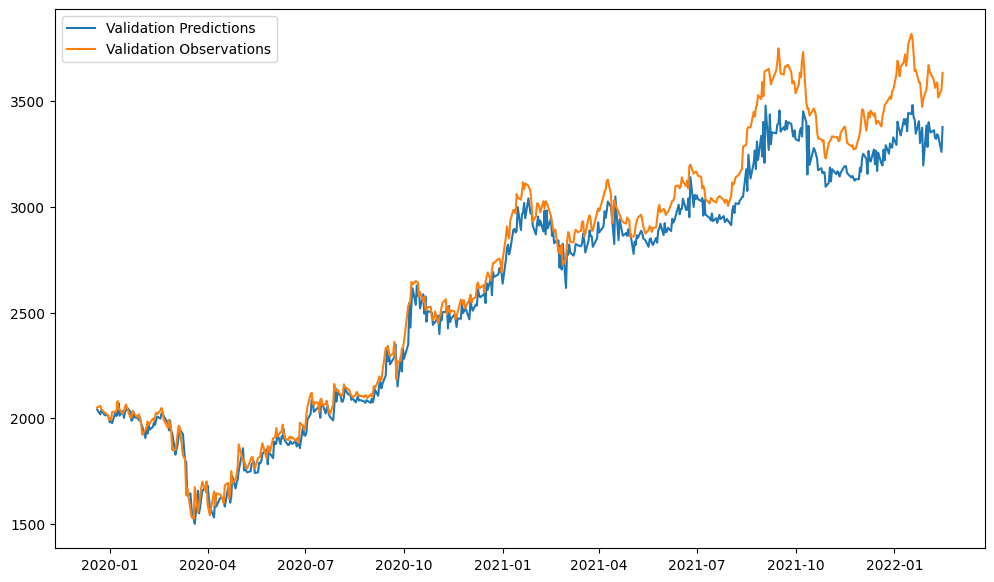

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(dates_val, val_predictions_rvsc)
plt.plot(dates_val, y_val_rvsc)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [25]:
test_predictions = model.predict(X_test).flatten().reshape(-1,1)

17/17 [==============================] - 0s 15ms/step


In [26]:
ttest = np.repeat(test_predictions, df_for_training.shape[1], axis=-1)
test_predictions_rvsc = scaler.inverse_transform(ttest)[:,4]

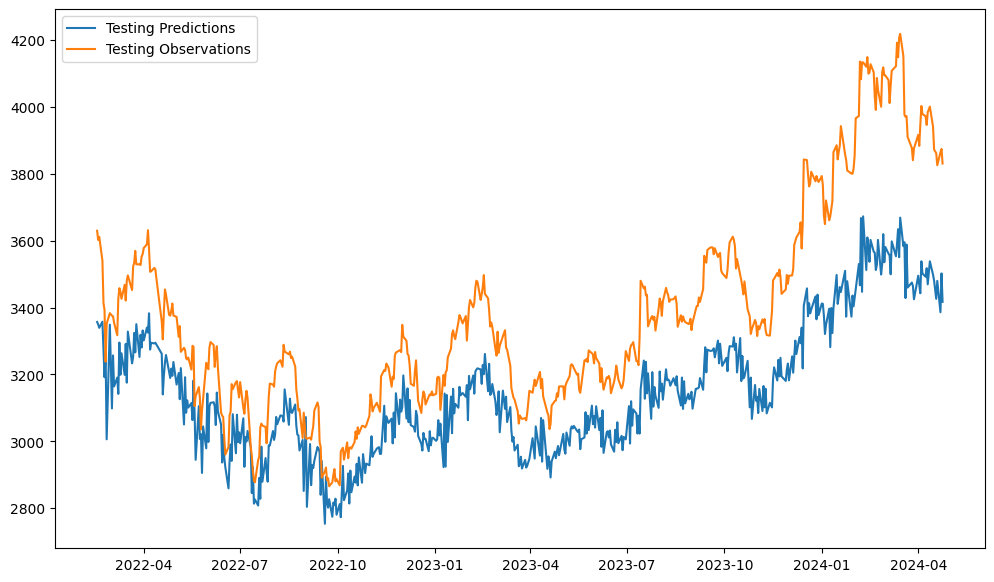

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(dates_test, test_predictions_rvsc)
plt.plot(dates_test, y_test_rvsc)
plt.legend(['Testing Predictions', 'Testing Observations'])

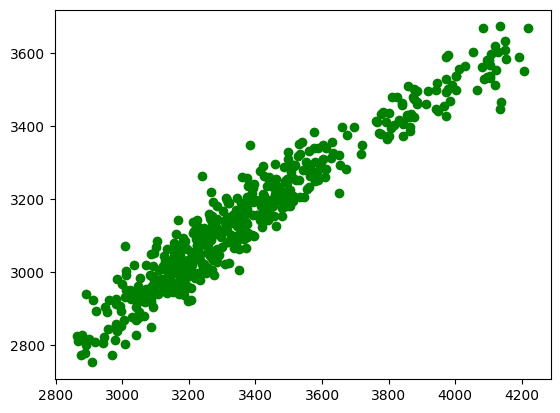

In [28]:
plt.scatter(y_test_rvsc,test_predictions_rvsc, color = "g")